In [11]:
%matplotlib notebook
import sshtunnel
import socket, pickle
import time
import scipy.signal as sig

In [7]:
SERVER_IP = 'XXX.XXX.XXX.XXX'  # IP address of Raspberry Pi
SERVER_PORT = 22
LOCALHOST = '127.0.0.1'
PORT = 65432
BLOCKSIZE = 1024

def connect_test(tr, sampling_freq, num_dummyscan):
    
    with socket.socket(socket.AF_INET, socket.SOCK_STREAM) as s:
        s.connect((HOST, PORT))
        code = '{}_{}_{}'.format(tr, sampling_freq, num_dummyscan)
        s.send(str.encode(code))

        data =[]
        while True:
            packet = s.recv(BLOCKSIZE)
            if not packet: break
            data.append(packet)
        data = b''.join(data)

    data = pickle.loads(data)
    print('Received')
    return data

with sshtunnel.open_tunnel((SERVER_IP, SERVER_PORT),
                           ssh_username="pi",
                           ssh_pkey="~/.ssh/rsa_key", # private key for security (this material will not cover this)
                           remote_bind_address=(LOCALHOST, PORT),
                           local_bind_address=(LOCALHOST, PORT)
                          ) as tunnel:
    output = []
    for f in [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]:
        output.append(connect_test(1, f, 1))
        time.sleep(3) # wait server re-initiation.
    
    pickle.dump(output, open('freq_record.pkl', 'wb'))

Received
Received
Received
Received
Received
Received
Received
Received
Received
Received


In [8]:
import pickle
test_data = pickle.load(open('freq_record.pkl', 'rb'))

- btm = body temperature
- vsp = vascular pulse
- rsp = respiration

<IPython.core.display.Javascript object>


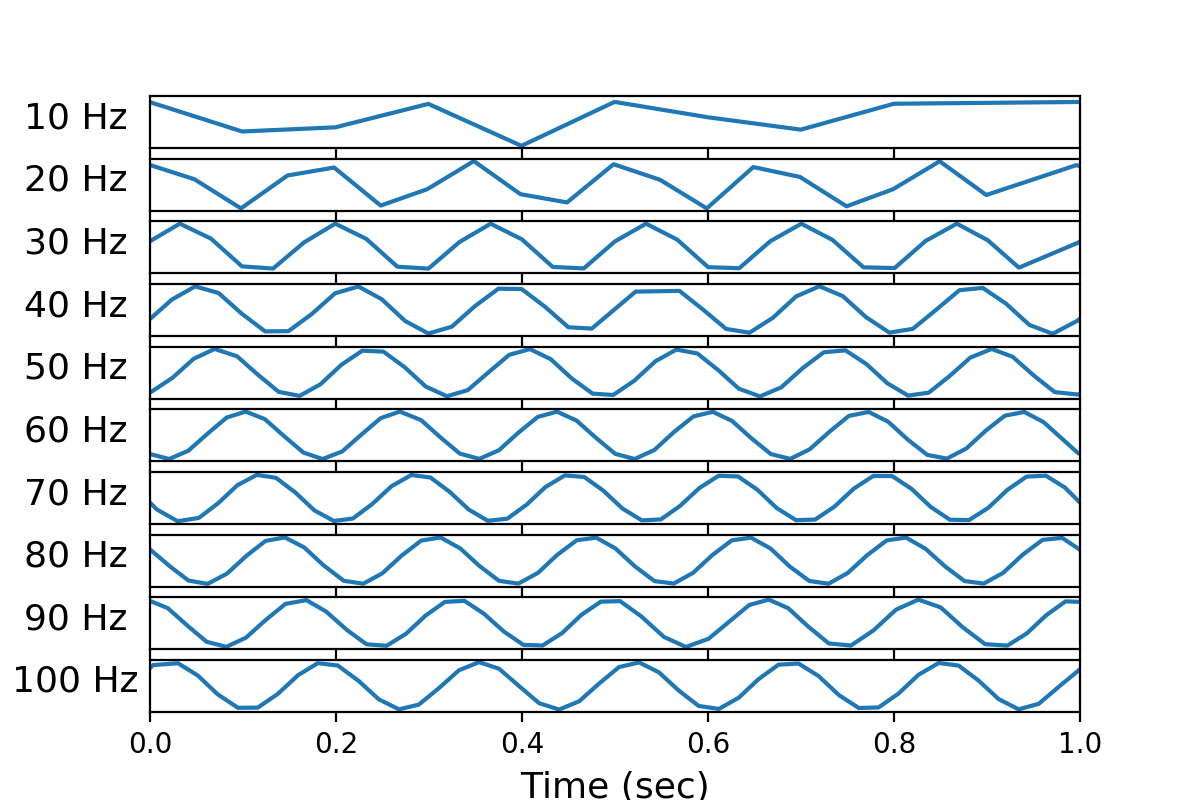

Text(0.5, 0, 'Time (sec)')

In [9]:
fig, axes = plt.subplots(10, 1, figsize=[6, 4], dpi=100, sharex=True)
axes = axes.flatten()

parameter = 'vsp'
freq = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

for i, ax in enumerate(axes):
    ax.plot(np.array(test_data[i]['ts'])-1, test_data[i][parameter])
    ax.set_ylabel('{} Hz'.format(freq[i]), rotation=0, fontsize=13)
    ax.get_yaxis().set_ticks([])
    ax.yaxis.set_label_coords(-0.08,0.25)

plt.xlim([0, 1])
plt.xlabel('Time (sec)', fontsize=13)

<IPython.core.display.Javascript object>


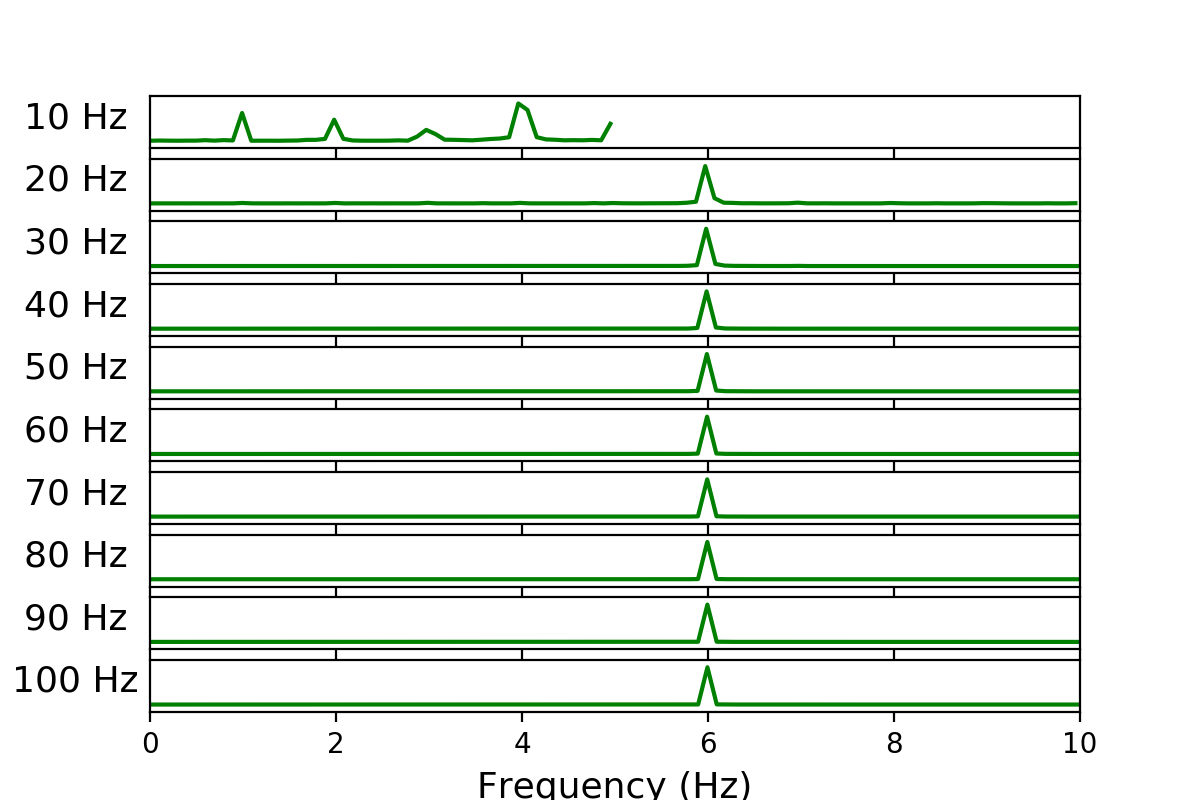

(0, 10)

In [12]:
fig, axes = plt.subplots(10, 1, figsize=[6, 4], dpi=100, sharex=True)
axes = axes.flatten()
from scipy.signal import periodogram
from scipy.interpolate import interp1d

parameter = 'vsp'

freq = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
for i, ax in enumerate(axes):
    x = test_data[i]['ts']
    y = test_data[i][parameter]
    x_ = np.linspace(0, 10, (freq[i]*10)+1)
    f_ = interp1d(x, y)
    y_ = f_(x_)
    f, p = sig.periodogram(y_, 1/np.diff(x_).mean())
    
    ax.plot(f, p, color='green')
    ax.set_ylabel('{} Hz'.format(freq[i]), rotation=0, fontsize=13)
    ax.get_yaxis().set_ticks([])
    ax.yaxis.set_label_coords(-0.08,0.25)
    p_max = p.max()
    ax.set_ylim([0-p_max*0.2, p_max*1.2])

# plt.xlim()
plt.xlabel('Frequency (Hz)', fontsize=13)
plt.xlim([0, 10])

<IPython.core.display.Javascript object>


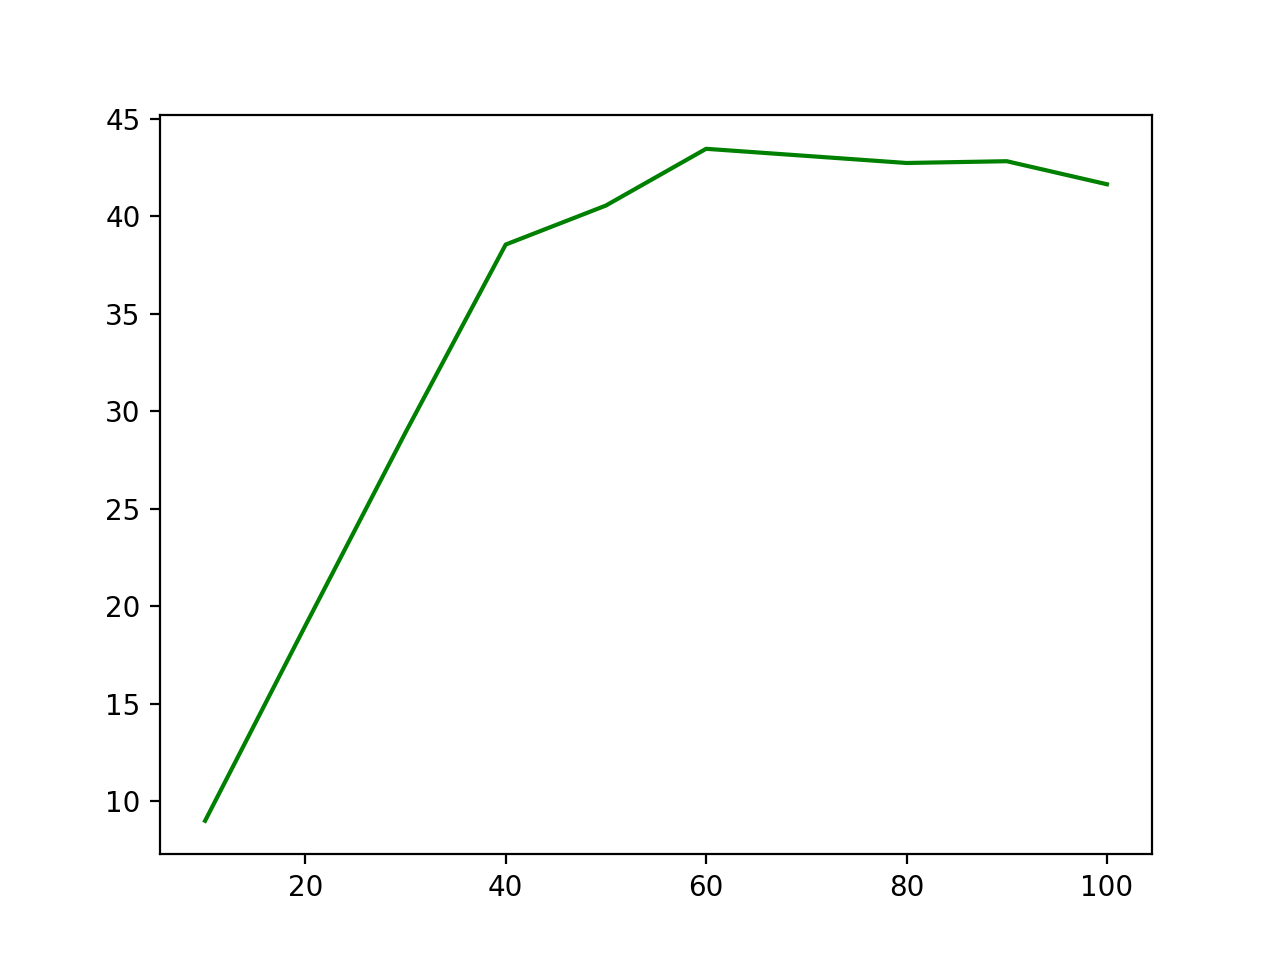

In [14]:
output = []
for d in test_data:
    sampling_ratio = len(d['ts'])/len(d['tt'])
    output.append(sampling_ratio)
plt.plot(freq, output, color='green')

9.483175900103335 1.4966691751945336
19.48862764375937 2.058552884369872
29.412460316346166 2.595012257358974
38.98536616731524 2.836534097105185
40.953106828923936 3.6130912606572476
43.962145600644696 3.7612765805627273
43.447494447423104 3.3949895625679436
43.06747215057958 3.543920703082727
43.03608409291206 3.268911710903333
41.75532393677891 3.3716580515994843


<IPython.core.display.Javascript object>


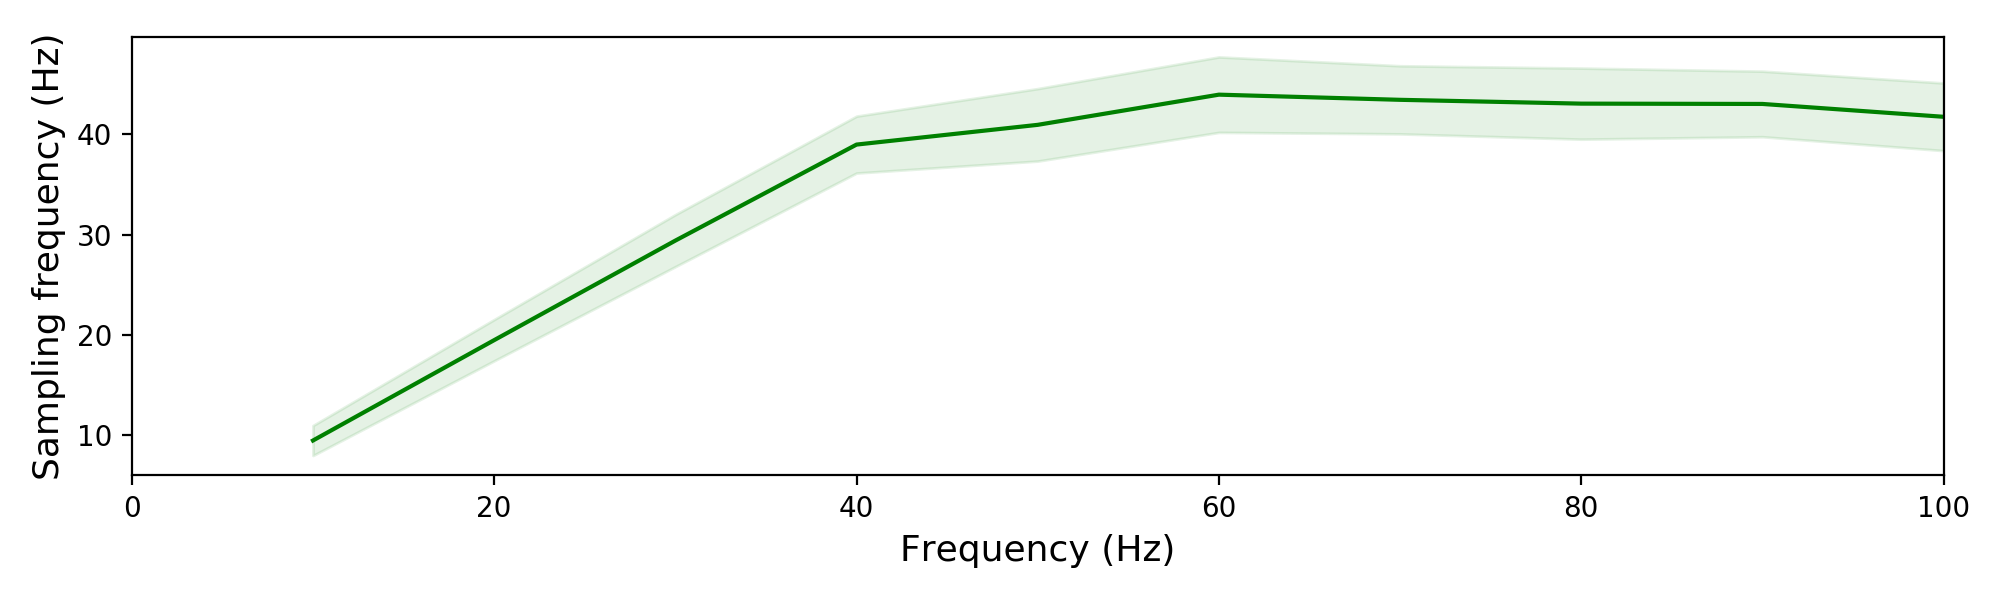

In [15]:
mean_freqs = []
std_freqs = []

for d in test_data:
    samp_freq = (1/np.diff(d['ts']))
    mean_freq = samp_freq.mean()
    std_freq = samp_freq.std()
    print(mean_freq, std_freq)
    mean_freqs.append(mean_freq)
    std_freqs.append(std_freq)
    
mean_freqs = np.array(mean_freqs)
std_freqs = np.array(std_freqs)

fig, ax = plt.subplots(1, 1, figsize=[10, 3])

ax.plot(freq, mean_freqs, color='green')
ax.fill_between(freq, mean_freqs-std_freqs, mean_freqs+std_freqs, color='green', alpha=0.1)
ax.set_xlabel('Frequency (Hz)', fontsize=13)
ax.set_ylabel('Sampling frequency (Hz)', fontsize=13)
ax.set_xlim([0, 100])
plt.tight_layout()